In [1]:
import jwst
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import match_coordinates_sky,SkyCoord, Angle
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

band = "clear-f444w"
path = "../../ngc3324/NIRCAM_ALL/JWST/jw02731-o001_t017_nircam_"

In [2]:
# band = 'f770w'
t = Table.read(path+band+"/jw02731-o001_t017_nircam_"+band+"_cat.ecsv")

t.info()

<Table length=19438>
         name           dtype    unit  format                                                                  description                                                                    class   n_bad
---------------------- ------- ------- ------ ---------------------------------------------------------------------------------------------------------------------------------------------- -------- -----
                 label   int64                                                                                                                     Unique source identification label number   Column     0
             xcentroid float64            .4f                                                                                                           X pixel value of the source centroid   Column     0
             ycentroid float64            .4f                                                                                                           Y pixel val

To brute force make a catalogue:

1) Start with the filter that has the most sources
2) Take the brightest source, grab it's RA/DEC, relate the size of it's 1-sigma psf size to deg and use this as tolerance.
3) Find all other objects in all other filters that are located within this tolerance
4) Take those filter mags/fluxes and plop into new dataframe
5) If one source has multiple objects associated with it in other filters, add them all into the rows and add a flag

In [3]:

path = "../../ngc3324/NIRCAM_ALL/JWST/jw02731-o001_t017_nircam_"
path_m = "../../ngc3324/MIRI_ALL/JWST/jw02731-o002_t017_miri_"
t = []

for i, band in enumerate(['clear-f090w', 'clear-f187n', 'clear-f200w', 'clear-f335m', 'clear-f444w', 'f444w-f470n']):
    # Get the tables
    t.append(Table.read(path+band+"/jw02731-o001_t017_nircam_"+band+"_cat.ecsv"))
    print(len(t[i]))


for i, band in enumerate(['f770w', 'f1130w', 'f1280w', 'f1800w']):
    # Get the tables
    t.append(Table.read(path_m+band+"/jw02731-o002_t017_miri_"+band+"_cat.ecsv"))
    print(len(t[i+6]))



20401
32372
44867
16663
19438
18984
592
412
410
310


In [4]:

# data_S = data_s[['RA', 'DEC', ap_type+'_'+meas_type+'_f200w', ap_type+'_'+meas_type+'_err_f200w', 'size']]
# data_S.sort_values(ap_type+'_'+meas_type+'_f200w',ascending=True,inplace=True)
# data_S.reset_index(drop=True,inplace=True)
# data_S

In [5]:
meas_type = 'vegamag'
ap_type = 'isophotal'
ap_type2 = 'aper30'
ap_type3 = 'aper50'
ap_type4 = 'aper70'
ap_type5 = 'aper_total'

for i, f in enumerate(['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']):
    print(f)
    if i < 3:
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.031/3600 # Convert pixels to arcseconds, arcseconds to degrees
    else:
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.063/3600
    
    t[i] = t[i].to_pandas()[['sky_centroid.ra', 'sky_centroid.dec', ap_type+'_'+meas_type, ap_type+'_'+meas_type+'_err', \
        ap_type2+'_'+meas_type, ap_type2+'_'+meas_type+'_err', ap_type3+'_'+meas_type, ap_type3+'_'+meas_type+'_err',\
            ap_type4+'_'+meas_type, ap_type4+'_'+meas_type+'_err',ap_type5+'_'+meas_type, ap_type5+'_'+meas_type+'_err','size']]
    t[i].rename(columns={'sky_centroid.ra': 'RA', 'sky_centroid.dec': 'DEC',ap_type+'_'+meas_type:ap_type+'_'+meas_type+'_'+f, ap_type+'_'+meas_type+'_err': ap_type+'_'+meas_type+'_err_'+f,\
        ap_type2+'_'+meas_type:ap_type2+'_'+meas_type+'_'+f, ap_type2+'_'+meas_type+'_err': ap_type2+'_'+meas_type+'_err_'+f,ap_type3+'_'+meas_type:ap_type3+'_'+meas_type+'_'+f, ap_type+'_'+meas_type+'_err': ap_type+'_'+meas_type+'_err_'+f,\
            ap_type4+'_'+meas_type:ap_type4+'_'+meas_type+'_'+f, ap_type4+'_'+meas_type+'_err': ap_type4+'_'+meas_type+'_err_'+f,ap_type5+'_'+meas_type:ap_type5+'_'+meas_type+'_'+f, ap_type5+'_'+meas_type+'_err': ap_type5+'_'+meas_type+'_err_'+f},inplace=True)

data_all_filters_NIRCam_MIRI = pd.concat([t[0],t[1],t[2],t[3],t[4],t[5]],ignore_index=True) # MIRI: ,t[6],t[7],t[8],t[9]
data_all_filters_NIRCam_MIRI.sort_values(ap_type+'_'+meas_type+'_f444w', ascending=True,inplace=True)
data_all_filters_NIRCam_MIRI.reset_index(drop=True,inplace=True)

f090w
f187n
f200w
f335m
f444w
f444w-f470n
f770w
f1130w
f1280w
f1800w


In [6]:
data_all_filters_NIRCam_MIRI

,RA,DEC,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,aper30_vegamag_f090w,aper30_vegamag_err_f090w,aper50_vegamag_f090w,aper50_vegamag_err,aper70_vegamag_f090w,aper70_vegamag_err_f090w,...,aper_total_vegamag_err_f444w,isophotal_vegamag_f444w-f470n,isophotal_vegamag_err_f444w-f470n,aper30_vegamag_f444w-f470n,aper30_vegamag_err_f444w-f470n,aper50_vegamag_f444w-f470n,aper70_vegamag_f444w-f470n,aper70_vegamag_err_f444w-f470n,aper_total_vegamag_f444w-f470n,aper_total_vegamag_err_f444w-f470n
0,159.224613,-58.608239,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,159.252106,-58.638487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.007578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,159.268010,-58.580141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,159.178524,-58.562077,NaN,NaN,NaN,NaN,NaN,11.461657,NaN,NaN,...,10.822634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,159.251049,-58.592654,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,7.368082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152720,159.296183,-58.593406,NaN,NaN,NaN,NaN,NaN,14.765570,NaN,NaN,...,NaN,18.923481,14.819511,18.983592,14.783308,18.900061,19.004207,NaN,18.574891,NaN
152721,159.287218,-58.613990,NaN,NaN,NaN,NaN,NaN,15.775395,NaN,NaN,...,NaN,20.915332,15.630869,21.820916,16.080535,21.147950,20.263911,NaN,19.834595,NaN
152722,159.303201,-58.577420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.899702,13.348217,19.038842,13.674720,18.411682,17.909143,NaN,17.479827,NaN
152723,159.291852,-58.603410,NaN,NaN,NaN,NaN,NaN,15.486526,NaN,NaN,...,NaN,20.321564,15.430135,20.787425,15.616199,20.365494,21.079177,16.793009,20.649861,16.793009


In [179]:
def strip_cand(df, tol=1/3600):
    """
    Originally written by S. Smith, UVic 2022, edited by B. Crompvoets UVic 2022

    For a pandas dataframe filled with unsorted candidates, 
    select the first row, select all neighbours within the df, 
    and keep only the most significant. Strip all neighbours and 
    reference source from the original df. Return the striped df, 
    along with the row values of the most significant member.
    
    Parameters:
    -----------
    
    df  : Pandas DataFrame object, candidates
    tol : Neighbour tollerance, in degrees (recommended, tol = 0.5)
    
    Returns:
    -----------
    
    rest  : Pandas Dataframe object, striped of one candidate member group
    row : Numpy Array object, highest significance candidate from group
    """
    
    i, j = df.iloc[0]['RA'], df.iloc[0]['DEC'] #Select RA/Dec of first item in the df
    prox = np.sqrt((df['RA']-i)**2 + (df['DEC']-j)**2) < 1.5*tol #Find boolean locations of all neighbours within tol (in degrees)
    invest = df[prox].sort_values(ap_type+'_'+meas_type+'_f444w', ascending=True).reset_index(drop=True) #Define new df 'investigate' made up of all group members
    if invest.shape[0] > 6:
        print("Triggered")
        print(invest.shape[0])
        # closest = np.sqrt((invest.RA-i)**2+(invest.DEC-j)**2)
    #row = np.array(invest.iloc[0]) #Take highest sig group member and put in np.array object
    rest = df[~prox].reset_index(drop=True) #Define new df 'the rest' made up of all the other rows
    
    return rest, invest

In [180]:
length = True
i = 0

rest, row = strip_cand(data_all_filters_NIRCam_MIRI,tol=data_all_filters_NIRCam_MIRI['size'])

for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n']:
    if not row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy():
        row.loc[0,ap_type+'_'+meas_type+'_'+f] = np.nan
        row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = np.nan
    else:
        row.loc[0,ap_type+'_'+meas_type+'_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy()[0]
        row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_err_'+f)[ap_type+'_'+meas_type+'_err_'+f].to_numpy()[0]

catalog = row.head(1)
print(np.shape(row))
while length:
    rest, row = strip_cand(rest,tol=rest['size'])
    
    for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n']:
        if not row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy().any():
            row.loc[0,ap_type+'_'+meas_type+'_'+f] = np.nan
            row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = np.nan
        else:
            row.loc[0,ap_type+'_'+meas_type+'_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy()[0]
            if not row.dropna(subset=ap_type+'_'+meas_type+'_err_'+f)[ap_type+'_'+meas_type+'_err_'+f].to_numpy().any():
                row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = np.nan
            else:
                row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_err_'+f)[ap_type+'_'+meas_type+'_err_'+f].to_numpy()[0]
    
    row = row.head(1)

    catalog = pd.concat([catalog, row])

    length = len(rest) > 0
    if i % 10000 == 0:
        print(len(rest))
    i = i+1
catalog.reset_index(inplace=True,drop=True)

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/1530439419.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy():


(5, 58)
152715
Triggered
8
Triggered
7
Triggered
7
Triggered
8
110228
83891
68982
56884
46039
35546
25452
15262
4981


In [181]:
# _, row = strip_cand(data_all_filters_NIRCam_MIRI,tol=data_all_filters_NIRCam_MIRI['size'])

# for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n']:
#     if not row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy():
#         row.loc[0,ap_type+'_'+meas_type+'_'+f] = np.nan
#         row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = np.nan
#     else:
#         row.loc[0,ap_type+'_'+meas_type+'_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy()[0]
#         row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_err_'+f)[ap_type+'_'+meas_type+'_err_'+f].to_numpy()[0]

print(row[bands[:6]].head(1))

row

   isophotal_vegamag_f090w  isophotal_vegamag_f187n  isophotal_vegamag_f200w  \
0                      NaN                      NaN                      NaN   

   isophotal_vegamag_f335m  isophotal_vegamag_f444w  \
0                      NaN                      NaN   

   isophotal_vegamag_f444w-f470n  
0                      20.321564  


,RA,DEC,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,aper30_vegamag_f090w,aper30_vegamag_err_f090w,aper50_vegamag_f090w,aper50_vegamag_err,aper70_vegamag_f090w,aper70_vegamag_err_f090w,...,aper_total_vegamag_err_f444w,isophotal_vegamag_f444w-f470n,isophotal_vegamag_err_f444w-f470n,aper30_vegamag_f444w-f470n,aper30_vegamag_err_f444w-f470n,aper50_vegamag_f444w-f470n,aper70_vegamag_f444w-f470n,aper70_vegamag_err_f444w-f470n,aper_total_vegamag_f444w-f470n,aper_total_vegamag_err_f444w-f470n
0,159.291852,-58.60341,NaN,NaN,NaN,NaN,NaN,15.486526,NaN,NaN,...,NaN,20.321564,15.430135,20.787425,15.616199,20.365494,21.079177,16.793009,20.649861,16.793009


In [182]:
catalog.reset_index(inplace=True,drop=True)
print(len(catalog))
catalog

94977


,RA,DEC,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,aper30_vegamag_f090w,aper30_vegamag_err_f090w,aper50_vegamag_f090w,aper50_vegamag_err,aper70_vegamag_f090w,aper70_vegamag_err_f090w,...,aper_total_vegamag_err_f444w,isophotal_vegamag_f444w-f470n,isophotal_vegamag_err_f444w-f470n,aper30_vegamag_f444w-f470n,aper30_vegamag_err_f444w-f470n,aper50_vegamag_f444w-f470n,aper70_vegamag_f444w-f470n,aper70_vegamag_err_f444w-f470n,aper_total_vegamag_f444w-f470n,aper_total_vegamag_err_f444w-f470n
0,159.224613,-58.608239,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,0.000000,7.618336,6.927048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,159.252106,-58.638487,10.044549,8.094974,NaN,NaN,NaN,NaN,NaN,NaN,...,16.007578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,159.268010,-58.580141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,159.178524,-58.562077,10.788224,8.623969,NaN,NaN,NaN,11.461657,NaN,NaN,...,10.822634,8.735966,8.203675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,159.251049,-58.592654,12.768613,8.807995,NaN,NaN,NaN,0.000000,NaN,NaN,...,7.368082,8.755222,7.645574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94972,159.298363,-58.588336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,19.189563,14.064150,20.959645,14.795026,20.220002,19.254287,NaN,18.824971,NaN
94973,159.292665,-58.601397,NaN,NaN,NaN,NaN,NaN,16.030067,NaN,NaN,...,NaN,20.697085,16.073114,21.100521,16.334863,20.649381,20.733478,16.383844,20.304162,16.383844
94974,159.296183,-58.593406,NaN,NaN,NaN,NaN,NaN,14.765570,NaN,NaN,...,NaN,18.923481,14.819511,18.983592,14.783308,18.900061,19.004207,NaN,18.574891,NaN
94975,159.287218,-58.613990,NaN,NaN,NaN,NaN,NaN,15.775395,NaN,NaN,...,NaN,20.915332,15.630869,21.820916,16.080535,21.147950,20.263911,NaN,19.834595,NaN


In [183]:
rest.columns

Index(['RA', 'DEC', 'isophotal_vegamag_f090w', 'isophotal_vegamag_err_f090w',
       'aper30_vegamag_f090w', 'aper30_vegamag_err_f090w',
       'aper50_vegamag_f090w', 'aper50_vegamag_err', 'aper70_vegamag_f090w',
       'aper70_vegamag_err_f090w', 'aper_total_vegamag_f090w',
       'aper_total_vegamag_err_f090w', 'size', 'isophotal_vegamag_f187n',
       'isophotal_vegamag_err_f187n', 'aper30_vegamag_f187n',
       'aper30_vegamag_err_f187n', 'aper50_vegamag_f187n',
       'aper70_vegamag_f187n', 'aper70_vegamag_err_f187n',
       'aper_total_vegamag_f187n', 'aper_total_vegamag_err_f187n',
       'isophotal_vegamag_f200w', 'isophotal_vegamag_err_f200w',
       'aper30_vegamag_f200w', 'aper30_vegamag_err_f200w',
       'aper50_vegamag_f200w', 'aper70_vegamag_f200w',
       'aper70_vegamag_err_f200w', 'aper_total_vegamag_f200w',
       'aper_total_vegamag_err_f200w', 'isophotal_vegamag_f335m',
       'isophotal_vegamag_err_f335m', 'aper30_vegamag_f335m',
       'aper30_vegamag_err_f335m

In [184]:
catalog_tab = Table.from_pandas(catalog[['RA','DEC','size',ap_type+'_'+meas_type+'_f090w', ap_type+'_'+meas_type+'_err_f090w', ap_type+'_'+meas_type+'_f187n', ap_type+'_'+meas_type+'_err_f187n',\
    ap_type+'_'+meas_type+'_f200w', ap_type+'_'+meas_type+'_err_f200w',ap_type+'_'+meas_type+'_f335m', ap_type+'_'+meas_type+'_err_f335m',ap_type+'_'+meas_type+'_f444w', ap_type+'_'+meas_type+'_err_f444w',\
        ap_type+'_'+meas_type+'_f444w-f470n', ap_type+'_'+meas_type+'_err_f444w-f470n']],units={'RA':'deg','DEC':'deg',ap_type+'_'+meas_type+'_f090w':'mag',ap_type+'_'+meas_type+'_err_f090w':'mag','size':'deg',\
            ap_type+'_'+meas_type+'_f187n':'mag',ap_type+'_'+meas_type+'_err_f187n':'mag',ap_type+'_'+meas_type+'_f200w':'mag',ap_type+'_'+meas_type+'_err_f200w':'mag',\
                ap_type+'_'+meas_type+'_f335m':'mag',ap_type+'_'+meas_type+'_err_f335m':'mag',ap_type+'_'+meas_type+'_f444w':'mag',ap_type+'_'+meas_type+'_err_f444w':'mag',\
                    ap_type+'_'+meas_type+'_f444w-f470n':'mag',ap_type+'_'+meas_type+'_err_f444w-f470n':'mag'})


catalog_tab

RA,DEC,size,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,isophotal_vegamag_f187n,isophotal_vegamag_err_f187n,isophotal_vegamag_f200w,isophotal_vegamag_err_f200w,isophotal_vegamag_f335m,isophotal_vegamag_err_f335m,isophotal_vegamag_f444w,isophotal_vegamag_err_f444w,isophotal_vegamag_f444w-f470n,isophotal_vegamag_err_f444w-f470n
deg,deg,deg,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
159.2246132832452,-58.60823887637141,0.0010911729484698867,--,--,11.743592171205284,9.224234264397804,11.416485829496683,8.303678006894708,10.133513145472966,6.898864059371301,8.72286966239931,6.138027333598953,7.61833641065077,6.92704760891259
159.2521061986519,-58.63848686920502,0.005063344763435925,10.044548541033652,8.094974227151896,8.912283197157022,8.458140440957049,9.042986377123162,7.575460001332392,8.8829130078359,6.354359219162031,8.725649118097706,6.209579772517281,--,--
159.26800988008208,-58.580141411648576,0.0032348670052667772,--,--,--,--,10.271229342784071,8.40781949289092,9.307424603644627,7.052662662522234,8.999676733417836,6.7747868162189295,--,--
159.17852375807573,-58.56207658992972,0.00147449597385509,10.78822369955855,8.623969261691549,8.925117992660969,8.931601111731963,9.253841878304577,8.113905206145013,9.154791980175446,7.299539733148387,9.411054790818492,7.225036322248682,8.73596623544298,8.203675492755567
159.25104881666056,-58.59265433436254,0.0013353876915208512,12.768612912073348,8.807994708862372,--,--,10.835843473836464,8.253004370046343,9.847233115592399,6.875178750728949,9.58816684924274,6.60797933046601,8.755221876810515,7.645574175850256
159.15621565553636,-58.64979522352271,0.0013002316792464295,11.546938119269784,8.923614227153553,--,--,9.72551101108441,7.923448860099049,--,--,9.859557792180585,6.6618782026869905,--,--
159.2043201561289,-58.66952580555881,0.0010075542119233351,--,--,--,--,--,--,11.791893984183318,8.484642947860307,9.894709261546849,7.320514845489761,9.389038269962064,8.575407831322506
159.15852734513905,-58.67415761068801,0.0009561273698564541,--,--,10.754608986202712,10.334783423379363,10.75950384961903,9.399501943169358,10.296708782659145,7.857944339354187,10.143199878811176,7.747931294407929,9.527383146130447,8.836620375733421


In [185]:

# catalog_tab.write('CC_JWST_Full_Nov042022_'+meas_type+'.ecsv', format='ascii.ecsv',overwrite=True)
catalog.to_csv('CC_JWST_Full_Nov152022_'+meas_type+'.csv')

# Now that we have a catalogue of all JWST data, link Spitzer/2MASS

In [186]:
jwst_cat = pd.read_csv('CC_JWST_Full_Nov152022_'+meas_type+'.csv')
# jwst_cat = catalog
spit2m_cat = pd.read_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/NGC_3324_w_Preds.csv')
spicy_cat = pd.read_csv('/Users/breannacrompvoets/Documents/Star_Formation/YSO+Classification/Archive/SPICY_YSO_SubClasses.csv',comment='#')

j_sky = SkyCoord(jwst_cat.RA*u.deg, jwst_cat.DEC*u.deg)
# # # jwst_cat.drop(['RA','DEC'], axis=1, inplace=True)
s2_sky = SkyCoord(spit2m_cat.RAJ2000*u.deg, spit2m_cat.DEJ2000*u.deg)
# sp_sky = SkyCoord(spicy_cat['     RAdeg      DEdeg'].to_numpy(),unit=u.deg)
# # spit2m_cat.drop(['RAJ2000','DEJ2000'], axis=1, inplace=True)


# print(jwst_cat.shape)
# print(spit2m_cat.shape)


In [187]:
idx, sep2d, x = match_coordinates_sky(j_sky, s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
sep_constraint = sep2d < np.array(jwst_cat['size']*2)*u.deg

print(np.count_nonzero(sep_constraint))

j_matches = jwst_cat[sep_constraint]
s2_matches = spit2m_cat.iloc[idx[sep_constraint]]

j_matches.reset_index(drop=True,inplace=True)
s2_matches.reset_index(drop=True,inplace=True)

jwst_spitz_cat = pd.concat([j_matches,s2_matches],axis=1)


jwst_spitz_cat[['size','RA','DEC','RAJ2000','DEJ2000',ap_type+'_'+meas_type+'_f444w','mag_IR2']].head()

497


,size,RA,DEC,RAJ2000,DEJ2000,isophotal_vegamag_f444w,mag_IR2
0,0.001091,159.224613,-58.608239,159.224953,-58.608123,8.722870,8.505
1,0.005063,159.252106,-58.638487,159.251615,-58.640301,8.725649,11.430
2,0.003235,159.268010,-58.580141,159.266513,-58.580279,8.999677,6.873
3,0.001474,159.178524,-58.562077,159.177449,-58.562715,9.411055,7.792
4,0.001335,159.251049,-58.592654,159.250809,-58.592758,9.588167,7.916


Text(0.5, 1.0, 'aper_total')

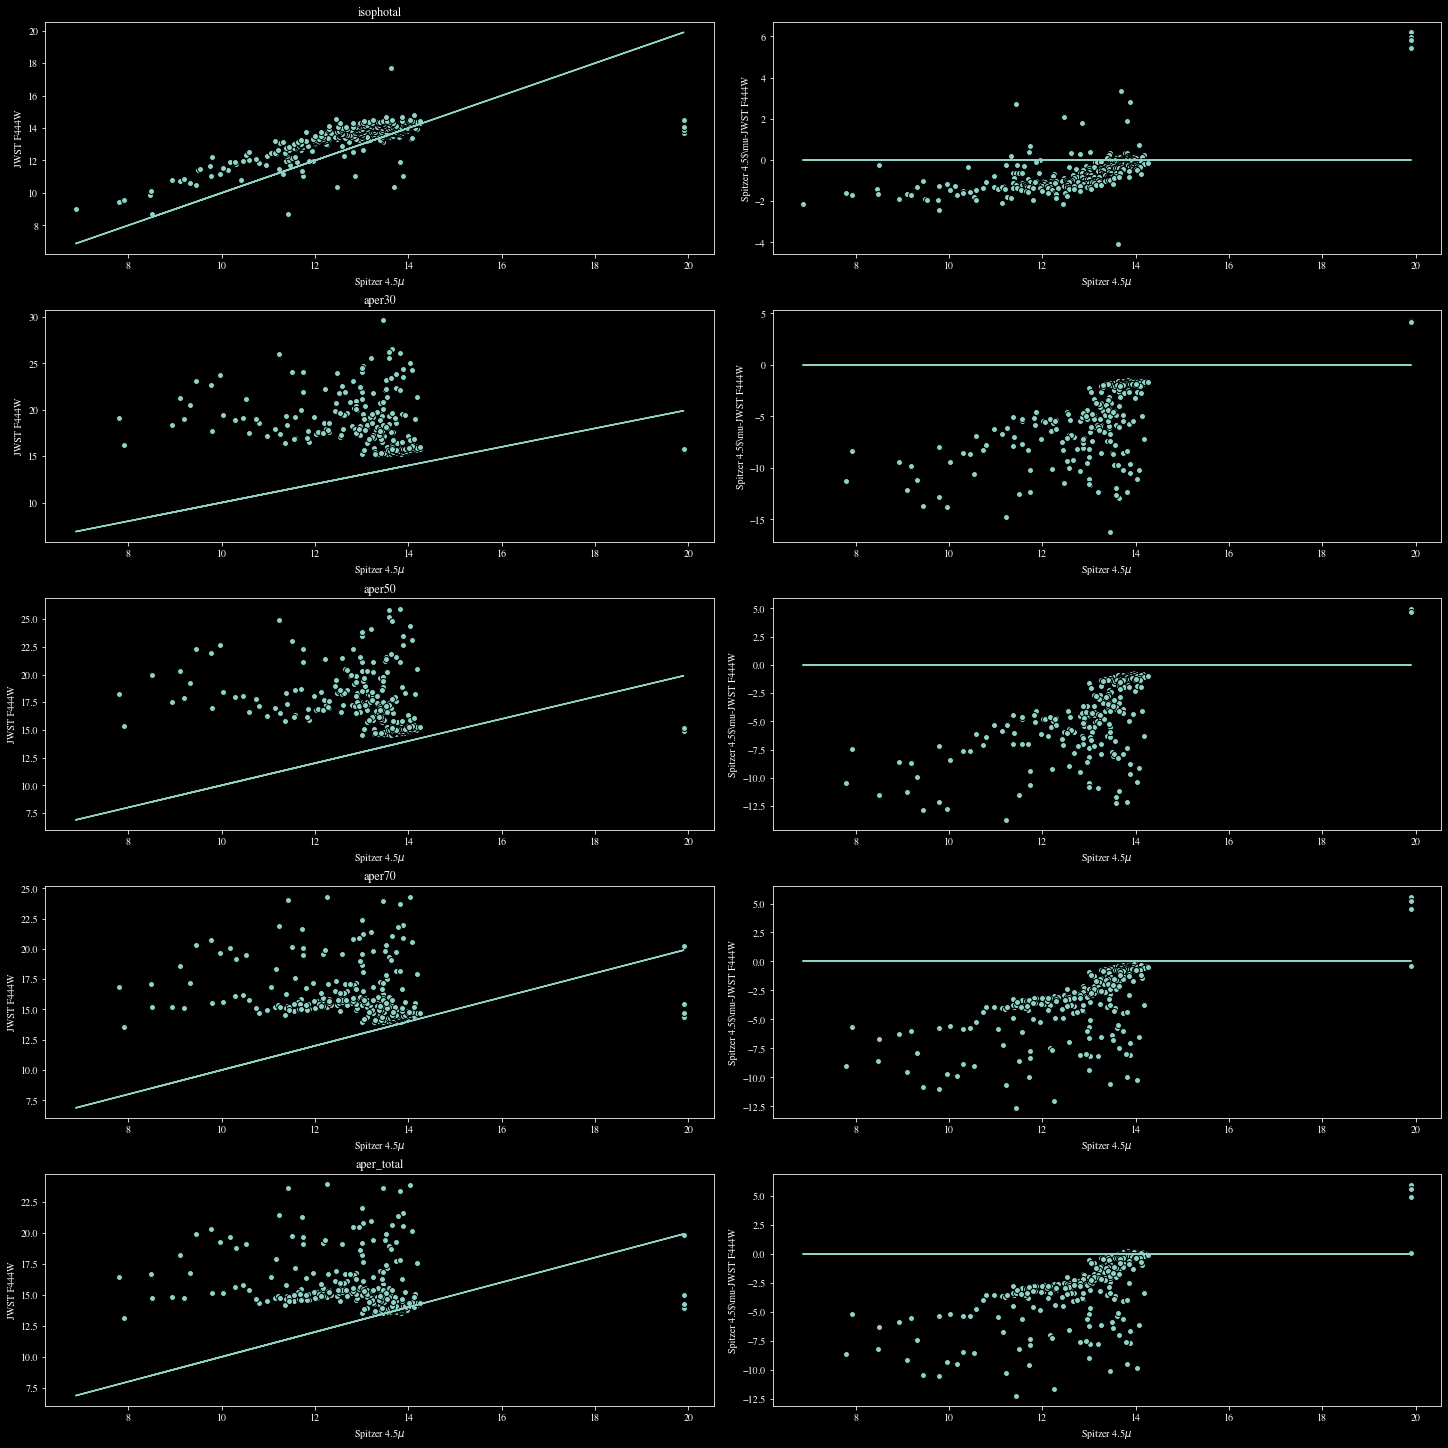

In [188]:
# plt.hist(jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],bins=np.linspace(-20,10,15))
# idx_1, sep2d_1, _ = match_coordinates_sky(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)), s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
# print(sep2d_1)
# spit2m_cat.iloc[idx_1]

fig, ax = plt.subplots(5,2,figsize=(20,20),constrained_layout=True)


ax[0][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
ax[0][0].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2)
ax[0][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
ax[0][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[0][0].set_ylabel('JWST F444W')
ax[0][0].set_xlabel('Spitzer 4.5$\mu$')

ax[0][1].set_ylabel('Spitzer 4.5$\mu-JWST F444W')
ax[0][1].set_xlabel('Spitzer 4.5$\mu$')

ax[0][0].set_title(ap_type)


ax[1][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
ax[1][0].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2)
ax[1][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
ax[1][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[1][0].set_ylabel('JWST F444W')
ax[1][0].set_xlabel('Spitzer 4.5$\mu$')

ax[1][1].set_ylabel('Spitzer 4.5$\mu-JWST F444W')
ax[1][1].set_xlabel('Spitzer 4.5$\mu$')

ax[1][0].set_title(ap_type2)


ax[2][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
ax[2][0].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2)
ax[2][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
ax[2][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[2][0].set_ylabel('JWST F444W')
ax[2][0].set_xlabel('Spitzer 4.5$\mu$')

ax[2][1].set_ylabel('Spitzer 4.5$\mu-JWST F444W')
ax[2][1].set_xlabel('Spitzer 4.5$\mu$')

ax[2][0].set_title(ap_type3)


ax[3][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
ax[3][0].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2)
ax[3][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
ax[3][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[3][0].set_ylabel('JWST F444W')
ax[3][0].set_xlabel('Spitzer 4.5$\mu$')

ax[3][1].set_ylabel('Spitzer 4.5$\mu-JWST F444W')
ax[3][1].set_xlabel('Spitzer 4.5$\mu$')

ax[3][0].set_title(ap_type4)



ax[4][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
ax[4][0].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2)
ax[4][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
ax[4][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[4][0].set_ylabel('JWST F444W')
ax[4][0].set_xlabel('Spitzer 4.5$\mu$')

ax[4][1].set_ylabel('Spitzer 4.5$\mu-JWST F444W')
ax[4][1].set_xlabel('Spitzer 4.5$\mu$')

ax[4][0].set_title(ap_type5)


In [189]:
# print(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)))
# idx_2, sep2d_2, _ = match_coordinates_sky(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)), j_sky, nthneighbor=1, storekdtree='kdtree_sky')
# jwst_cat.iloc[idx_2]

# jwst_spitz_cat.rename({'class    ':'Preds'},axis=1,inplace=True)

# jwst_spitz_cat.columns

[0. 1. 2.]


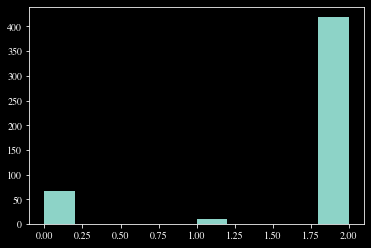

In [190]:
plt.hist(jwst_spitz_cat.Preds)

print(np.unique(jwst_spitz_cat.Preds))

# Locate all IR-Excess sources from Reiter 2022:


In [191]:
# IR-Excess sources found in Reiter 2022 (Diving off the Cosmic Cliffs)
reit = ["10:36:42.3 -58:38:04", "10:36:48.0 -58:38:19", "10:36:47.3 -58:38:10", "10:36:46.7 -58:38:05", "10:36:51.5 -58:37:54", "10:36:50.5 -58:37:52",\
    "10:36:51.4 -58:37:48", "10:36:53.8 -58:37:48", "10:36:51.5 -58:37:10", "10:36:54.2 -58:36:26", "10:36:54.4 -58:36:18", "10:36:54.0 -58:37:20",\
        "10:36:53.6 -58:35:20", "10:36:53.1 -58:37:37", "10:36:53.3 -58:37:54", "10:36:52.7 -58:38:05", "10:36:53.1 -58:37:08", "10:36:51.6 -58:36:58",\
        "10:36:52.3 -58:38:09", "10:36:53.9 -58:36:29", "10:37:01.5 -58:37:51", "10:37:02.1 -58:36:58", "10:36:53.9 -58:36:32"]# End of third row is the end of MHO-only sources
sky_1 = SkyCoord(reit,unit=(u.hourangle, u.deg))
ra_1 = sky_1.ra
dec_1 = sky_1.dec

reit_eg = ["10:36:53.7 -58:35:47", "10:36:59.5 -58:39:01", "10:37:07.2 -58:35:36", "10:36:55.2 -58:38:09"]
sky_1 = SkyCoord(reit_eg,unit=(u.hourangle, u.deg))
ra_eg = sky_1.ra
dec_eg = sky_1.dec


spicy = ["10:36:47.3 -58:38:10","10:36:54.0 -58:37:20","10:36:53.9 -58:36:29","10:37:02.1 -58:36:58","10:36:53.3 -58:37:54","10:36:52.3 -58:38:09"]
sky_1 = SkyCoord(spicy,unit=(u.hourangle, u.deg))
ra_spicy = sky_1.ra
dec_spicy = sky_1.dec

159.09784709430238


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574327 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654444171.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

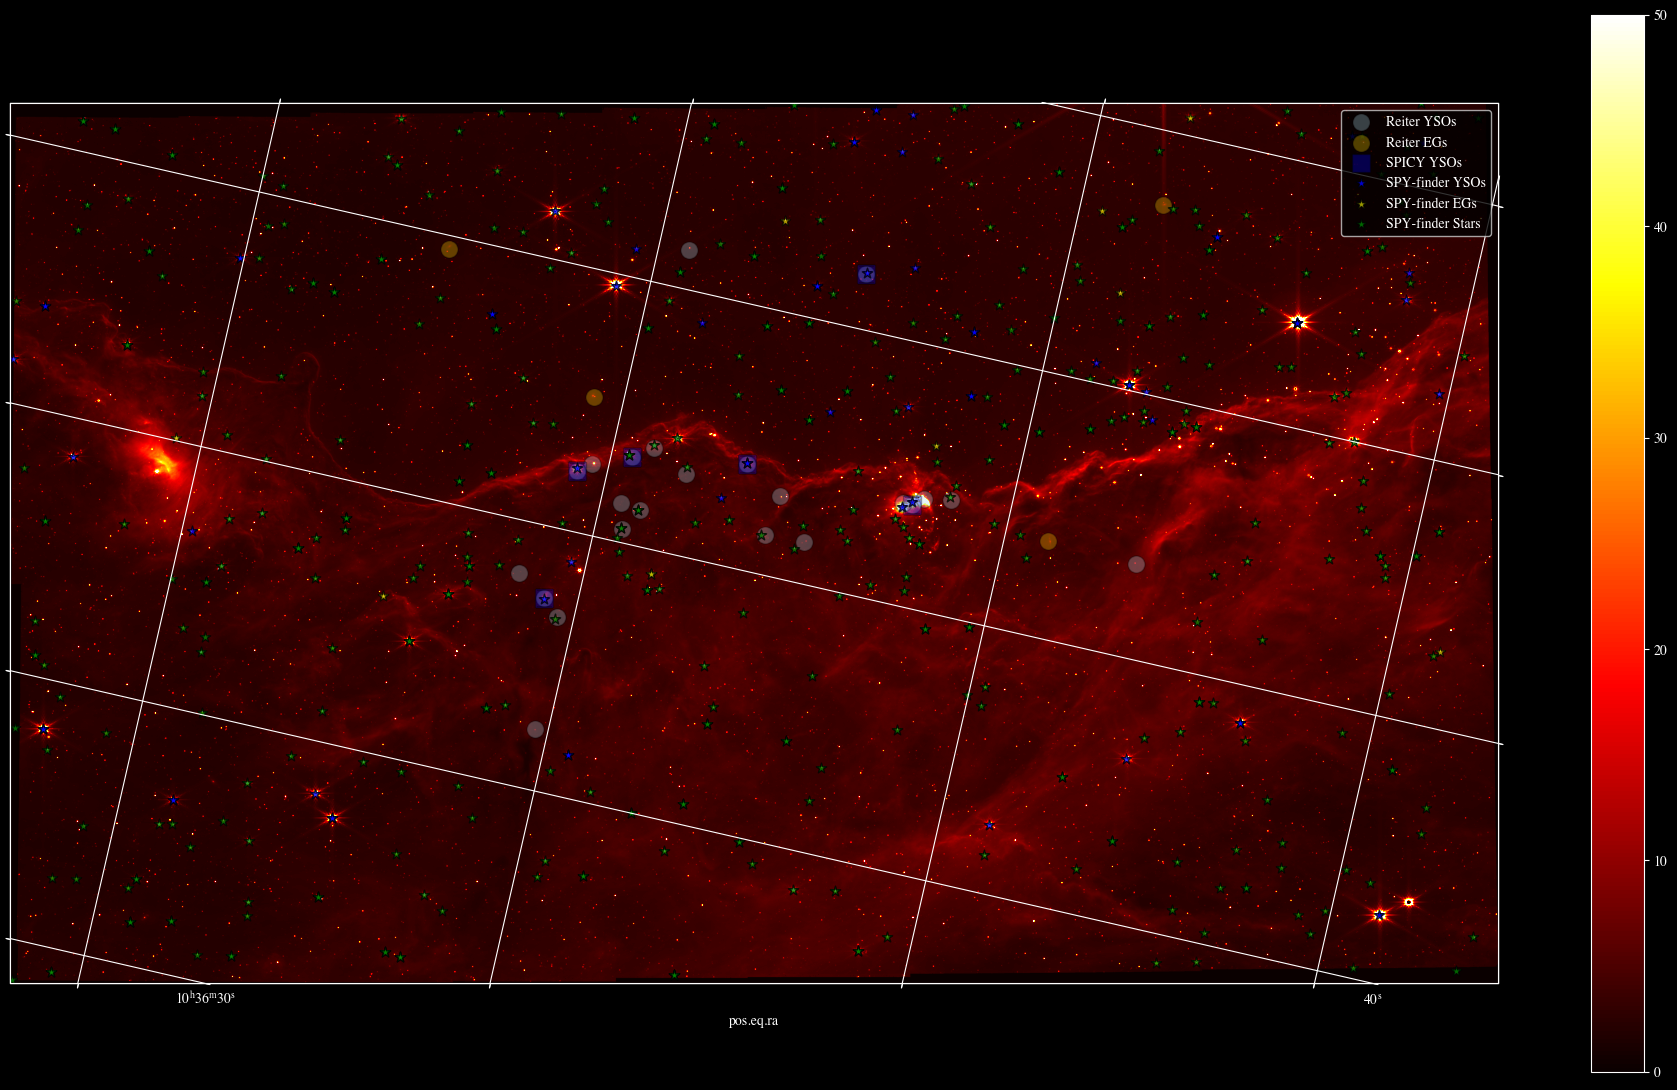

In [193]:
# Plot image
filter = "f444w"
image_file = f"../../ngc3324/FITS/JWST_{filter}.fits"


h = fits.getheader(image_file)

f = fits.open(image_file)

wcs = WCS(f[1].header)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(24,14),dpi=100)
ax = plt.subplot(projection=wcs)

plt.grid(color='white', ls='solid')
plt.imshow(f[1].data,cmap='hot',vmin=0,vmax=50,origin='lower') #vmax =1500 for f1800w
ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()
plt.colorbar()

ras, decs = wcs.wcs_pix2world(np.linspace(-500,15000,100), np.linspace(-500,16000,100), 1)
print(np.min(ras))

np8 = np.c_[np.array(jwst_spitz_cat.RAJ2000),np.array(jwst_spitz_cat.DEJ2000),np.array(jwst_spitz_cat.mag_IR2),np.array(jwst_spitz_cat.Preds)]

yso = np.where(np8[:,-1]==0)[0]
egs = np.where(np8[:,-1]==1)[0]
sta = np.where(np8[:,-1]==2)[0]

plt.scatter(ra_1,dec_1, marker='o', c='lightblue',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='Reiter YSOs')
plt.scatter(ra_eg,dec_eg, marker='o', c='gold',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='Reiter EGs')
# plt.scatter(np.array(jwst_spitz_cat.RA),np.array(jwst_spitz_cat.DEC), marker='s', c='b',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='SPICY YSOs')
plt.scatter(ra_spicy,dec_spicy, marker='s', c='b',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='SPICY YSOs')
ax.scatter(np8[yso,0],np8[yso,1], marker='*', c='b',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder YSOs")
ax.scatter(np8[egs,0],np8[egs,1], marker='*', c='y',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder EGs")
ax.scatter(np8[sta,0],np8[sta,1], marker='*', c='g',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder Stars")
ax.set_ylim(ymax, ymin)
ax.set_xlim(xmax, xmin)
plt.legend(loc=1)
plt.xticks()

# plt.savefig(f"../../ngc3324/CC_w_Reiter_RF_Label_{filter}.png",dpi=100)


In [197]:
jwst_spitz_cat.to_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/CC_Webb_Spitz_2m_w_Preds.csv')

In [29]:
# print('J'+np.array(jwst_spitz_cat.RA)+np.array(jwst_spitz_cat.DEC))
def deg_to_hrminsec(deg):
    deg = deg*u.deg
    h = deg.to(u.hourangle)/u.hourangle
    m = (h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:04.1f}".format(s)
def deghr_to_hrminsec(deg):
    h = deg
    # print(Angle(deg,u.hourangle).hms)
    m = 60-(h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:02d}".format(int(s))

jwst_num = []


for i, r in enumerate(np.array(jwst_spitz_cat.RA)):
    jwst_num.append('J'+deg_to_hrminsec(r)+deghr_to_hrminsec(np.array(jwst_spitz_cat.DEC)[i]))

In [30]:

jwst_spitz_cat['JWST_NUM'] = jwst_num
# jwst_spitz_cat[['JWST_NUM',' SPICY', 'Preds']]

# print(jwst_spitz_cat[['JWST_NUM',' SPICY']])
# for i, r in enumerate(np.array(jwst_spitz_cat.RA)):

In [196]:
jwst_spitz_cat['size']

0      0.001091
1      0.005063
2      0.003235
3      0.001474
4      0.001335
         ...   
492    0.000091
493    0.000067
494    0.000138
495    0.000396
496    0.000087
Name: size, Length: 497, dtype: float64

# Distribution of nan values and objects classified as YSOs/Stars

In [31]:
jwst_spitz_cat

,Unnamed: 0,RA,DEC,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,aper30_vegamag_f090w,aper30_vegamag_err_f090w,aper50_vegamag_f090w,aper50_vegamag_err,aper70_vegamag_f090w,...,e_mag_IR1,mag_IR2,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,alpha,Preds,JWST_NUM
0,0,159.224613,-58.608239,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,0.068,8.505,0.178,8.040,0.101000,6.691,0.106000,0.15496,0.0,J103653.9-583629
1,1,159.252106,-58.638487,10.044549,8.094974,NaN,NaN,NaN,NaN,NaN,...,0.049,11.430,0.059,11.342,0.083000,11.373,0.089000,-2.72652,2.0,J103700.5-583818
2,2,159.268010,-58.580141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.044,6.873,0.049,6.399,0.033000,5.622,0.024000,-0.76836,0.0,J103704.3-583448
3,3,159.178524,-58.562077,10.788224,8.623969,NaN,NaN,NaN,11.461657,NaN,...,0.040,7.792,0.054,7.715,0.037000,7.602,0.030000,-2.50840,0.0,J103642.8-583343
4,4,159.251049,-58.592654,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,0.056,7.916,0.042,7.082,0.033000,5.858,0.025000,0.55512,0.0,J103700.3-583533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,104400,159.262667,-58.638843,NaN,NaN,NaN,NaN,NaN,10.455963,NaN,...,0.103,13.987,0.187,18.524,0.144951,18.350,0.119339,-9.97532,2.0,J103703.0-583819
590,104603,159.252538,-58.674435,NaN,NaN,NaN,NaN,NaN,10.694038,NaN,...,0.059,12.058,0.068,11.944,0.109000,11.880,0.161000,-2.52808,2.0,J103700.6-584027
591,104679,159.277678,-58.621069,NaN,NaN,NaN,NaN,NaN,11.020387,NaN,...,0.118,14.037,0.281,18.524,0.144951,18.350,0.119339,-9.89332,2.0,J103706.6-583715
592,104797,159.254739,-58.682286,NaN,NaN,NaN,NaN,NaN,11.662877,NaN,...,0.045,12.753,0.103,12.481,0.192000,18.350,0.119339,-11.99908,2.0,J103701.1-584056


array([[<AxesSubplot:title={'center':'Preds'}>]], dtype=object)

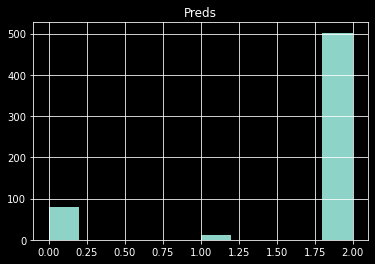

In [32]:
jwst_spitz_cat.hist('Preds')

In [33]:
np.count_nonzero(~np.isnan(jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w']))

339

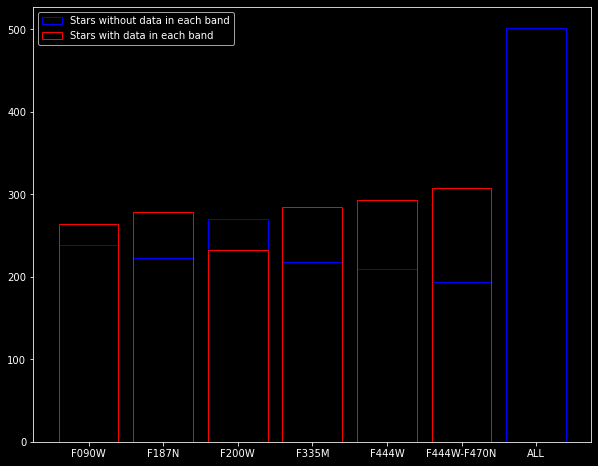

In [34]:
plt.subplots(figsize=(10,8))

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].shape[0] - jwst_spitz_cat.iloc[sta].dropna().shape[0]],fill=False,edgecolor='b',label='Stars without data in each band')

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].dropna().shape[0]],fill=False,edgecolor='r',label='Stars with data in each band')

# plt.plot(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
#     np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
#         np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
#             np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].dropna().shape[0]],color='r')
plt.legend()

80


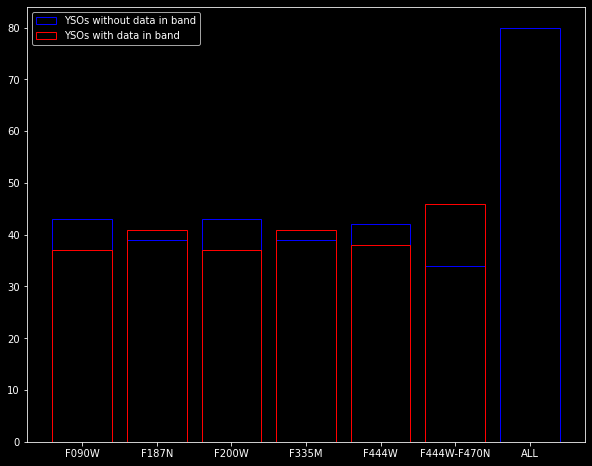

In [35]:
plt.subplots(figsize=(10,8))

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(np.isnan(jwst_spitz_cat.loc[yso][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[yso].shape[0] - jwst_spitz_cat.iloc[yso].dropna().shape[0]],fill=False,edgecolor='b',label='YSOs without data in band')


plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', "ALL"],[np.count_nonzero(~np.isnan(jwst_spitz_cat.loc[yso][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[yso].dropna().shape[0]],fill=False,edgecolor='r',label='YSOs with data in band')

print(jwst_spitz_cat.iloc[yso].shape[0])

plt.legend()

['isophotal_vegamag_f090w', 'isophotal_vegamag_f187n', 'isophotal_vegamag_f200w', 'isophotal_vegamag_f335m', 'isophotal_vegamag_f444w', 'isophotal_vegamag_f444w-f470n']


array([[<AxesSubplot:xlabel='isophotal_vegamag_f090w', ylabel='isophotal_vegamag_f090w'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f187n', ylabel='isophotal_vegamag_f090w'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f200w', ylabel='isophotal_vegamag_f090w'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f335m', ylabel='isophotal_vegamag_f090w'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f444w', ylabel='isophotal_vegamag_f090w'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f444w-f470n', ylabel='isophotal_vegamag_f090w'>],
       [<AxesSubplot:xlabel='isophotal_vegamag_f090w', ylabel='isophotal_vegamag_f187n'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f187n', ylabel='isophotal_vegamag_f187n'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f200w', ylabel='isophotal_vegamag_f187n'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f335m', ylabel='isophotal_vegamag_f187n'>,
        <AxesSubplot:xlabel='isophotal_vegamag_f444w', ylabel='isophotal_vegamag_f187n'>,
   

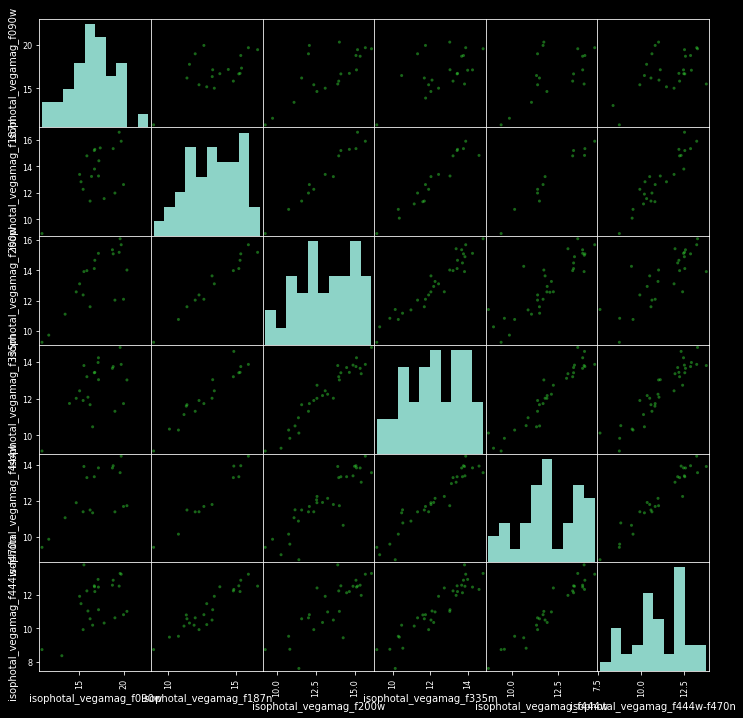

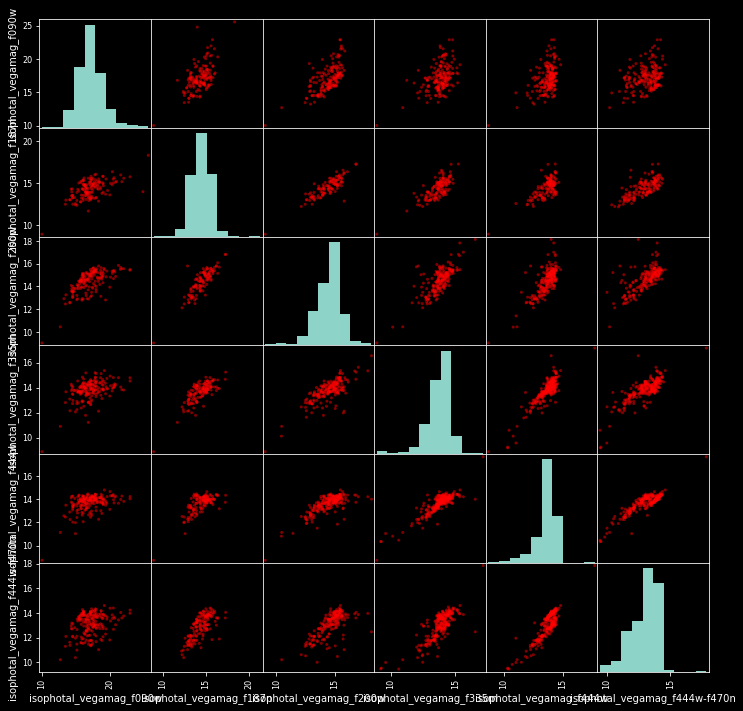

In [40]:
# plt.subplots(figsize=(12,12))

bands = [idx for idx in jwst_spitz_cat.columns if (idx[16:19] == 'g_f')] # 13:16 if aperxx photo
print(bands)
pd.plotting.scatter_matrix(jwst_spitz_cat.iloc[yso][bands],figsize=(12,12),color='limegreen')
pd.plotting.scatter_matrix(jwst_spitz_cat.iloc[sta][bands],figsize=(12,12),color='r')

In [41]:

# bands = [idx for idx in jwst_spitz_cat.columns if (idx[13:16] == 'g_f')]

bands

['isophotal_vegamag_f090w',
 'isophotal_vegamag_f187n',
 'isophotal_vegamag_f200w',
 'isophotal_vegamag_f335m',
 'isophotal_vegamag_f444w',
 'isophotal_vegamag_f444w-f470n']

(array([0.14141414, 0.36767677, 0.08484848, 0.31111111, 0.02828283,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([10.        , 11.07142857, 12.14285714, 13.21428571, 14.28571429,
        15.35714286, 16.42857143, 17.5       , 18.57142857, 19.64285714,
        20.71428571, 21.78571429, 22.85714286, 23.92857143, 25.        ]),
 [<matplotlib.patches.Polygon at 0x162dc5870>])

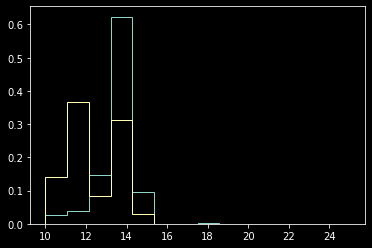

In [42]:
band = 'f444w'
plt.hist(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_'+band],bins=np.linspace(10,25,15),label='stars',density=True,histtype='step')
plt.hist(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_'+band],bins=np.linspace(10,25,15),label='ysos',density=True,histtype='step')

In [43]:
from sklearn.manifold import TSNE
print(bands)

['isophotal_vegamag_f090w', 'isophotal_vegamag_f187n', 'isophotal_vegamag_f200w', 'isophotal_vegamag_f335m', 'isophotal_vegamag_f444w', 'isophotal_vegamag_f444w-f470n']


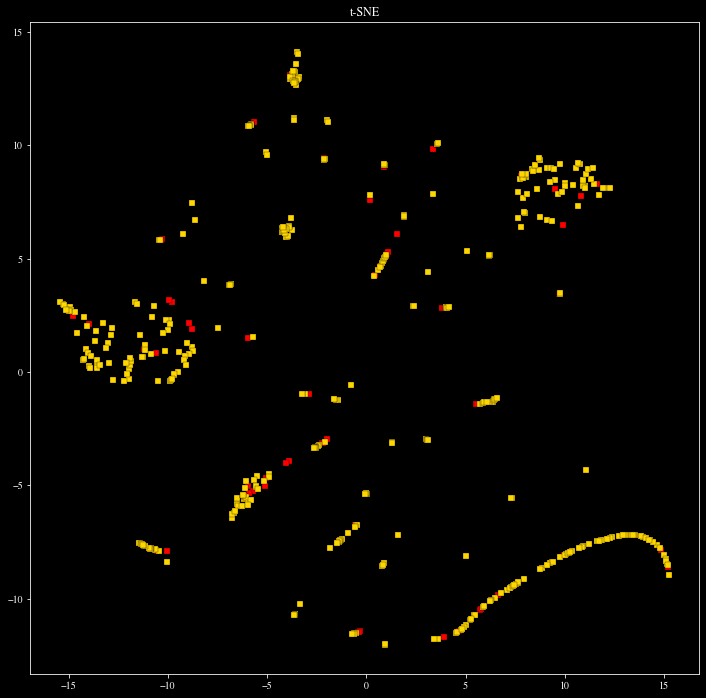

In [59]:
tsne = TSNE(
        n_components=2,
        init="random",
        random_state=11,
        perplexity=30,
        learning_rate="auto",
        n_iter=300)

droppna = jwst_spitz_cat.fillna(2)
Y = tsne.fit_transform(droppna[bands])

lw = 0.3

plt.subplots(figsize=(12,12))

plt.rcParams["scatter.edgecolors"]  = 'k'
plt.rcParams["font.family"] = "times"
plt.title("t-SNE")

plt.scatter(Y[np.where(droppna.Preds==0)[0], 0], Y[np.where(droppna.Preds==0)[0], 1], c="red",marker='s',linewidths=lw,label='Stars')
plt.scatter(Y[np.where(droppna.Preds==2)[0], 0], Y[np.where(droppna.Preds==2)[0], 1], c="gold",marker='s',linewidths=lw,label='EG')
    

In [64]:
droppna

,Unnamed: 0,RA,DEC,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,aper30_vegamag_f090w,aper30_vegamag_err_f090w,aper50_vegamag_f090w,aper50_vegamag_err,aper70_vegamag_f090w,...,e_mag_IR1,mag_IR2,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,alpha,Preds,JWST_NUM
0,0,159.224613,-58.608239,2.000000,2.000000,2.0,2.0,2.0,0.000000,2.0,...,0.068,8.505,0.178,8.040,0.101000,6.691,0.106000,0.15496,0.0,J103653.9-583629
1,1,159.252106,-58.638487,10.044549,8.094974,2.0,2.0,2.0,2.000000,2.0,...,0.049,11.430,0.059,11.342,0.083000,11.373,0.089000,-2.72652,2.0,J103700.5-583818
2,2,159.268010,-58.580141,2.000000,2.000000,2.0,2.0,2.0,2.000000,2.0,...,0.044,6.873,0.049,6.399,0.033000,5.622,0.024000,-0.76836,0.0,J103704.3-583448
3,3,159.178524,-58.562077,10.788224,8.623969,2.0,2.0,2.0,11.461657,2.0,...,0.040,7.792,0.054,7.715,0.037000,7.602,0.030000,-2.50840,0.0,J103642.8-583343
4,4,159.251049,-58.592654,2.000000,2.000000,2.0,2.0,2.0,0.000000,2.0,...,0.056,7.916,0.042,7.082,0.033000,5.858,0.025000,0.55512,0.0,J103700.3-583533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,104400,159.262667,-58.638843,2.000000,2.000000,2.0,2.0,2.0,10.455963,2.0,...,0.103,13.987,0.187,18.524,0.144951,18.350,0.119339,-9.97532,2.0,J103703.0-583819
590,104603,159.252538,-58.674435,2.000000,2.000000,2.0,2.0,2.0,10.694038,2.0,...,0.059,12.058,0.068,11.944,0.109000,11.880,0.161000,-2.52808,2.0,J103700.6-584027
591,104679,159.277678,-58.621069,2.000000,2.000000,2.0,2.0,2.0,11.020387,2.0,...,0.118,14.037,0.281,18.524,0.144951,18.350,0.119339,-9.89332,2.0,J103706.6-583715
592,104797,159.254739,-58.682286,2.000000,2.000000,2.0,2.0,2.0,11.662877,2.0,...,0.045,12.753,0.103,12.481,0.192000,18.350,0.119339,-11.99908,2.0,J103701.1-584056


In [78]:
bands = ['isophotal_vegamag_f090w', 'isophotal_vegamag_f187n', 'isophotal_vegamag_f200w', 'isophotal_vegamag_f335m', 'isophotal_vegamag_f444w', 'isophotal_vegamag_f444w-f470n', 'mag_J', 'mag_H', 'mag_Ks', 'mag_IR1', 'mag_IR2', 'mag_IR3', 'mag_IR4']
bands_IR = bands

print(bands)

['isophotal_vegamag_f090w', 'isophotal_vegamag_f187n', 'isophotal_vegamag_f200w', 'isophotal_vegamag_f335m', 'isophotal_vegamag_f444w', 'isophotal_vegamag_f444w-f470n', 'mag_J', 'mag_H', 'mag_Ks', 'mag_IR1', 'mag_IR2', 'mag_IR3', 'mag_IR4']


Preds    0.0
Name: 5, dtype: float64


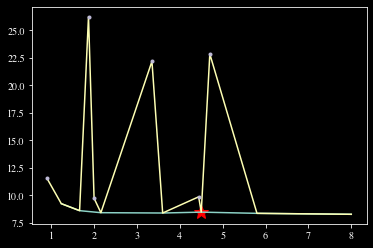

In [156]:
droppna = fillna
n = 5
x = [0.9,1.235,1.662,1.87,2.00,2.159,3.35,3.6,4.44,4.5,4.7,5.8,8.]
y = droppna[['isophotal_vegamag_f090w', 'mag_J', 'mag_H', 'isophotal_vegamag_f187n', 'isophotal_vegamag_f200w', 'mag_Ks', 'isophotal_vegamag_f335m', 'mag_IR1', 'isophotal_vegamag_f444w', 'mag_IR2', 'isophotal_vegamag_f444w-f470n','mag_IR3', 'mag_IR4']].iloc[n]
print(droppna[['Preds']].iloc[n])
plt.plot(4.5,droppna['mag_IR2'].iloc[n],'*',c='r',markersize=15)
plt.plot([1.235,1.662,2.159,3.6,4.5,5.8,8.],droppna[bands[6:]].iloc[n])
plt.plot(x,y)
plt.plot([0.9,1.87,2.00,3.35,4.44,4.7],droppna[['isophotal_vegamag_f090w', 'isophotal_vegamag_f187n', 'isophotal_vegamag_f200w', 'isophotal_vegamag_f335m', 'isophotal_vegamag_f444w', 'isophotal_vegamag_f444w-f470n']].iloc[n],'.')

In [155]:
cols = np.r_[bands, ['Preds']]
fillna = jwst_spitz_cat[cols]
for band in bands[:6]:
    print(band)
    min = np.nanmax(jwst_spitz_cat[[band]])
    print(min+5)
    fillna[band].fillna(min+5,inplace=True)


fillna.head()

isophotal_vegamag_f090w
30.56144249722696
isophotal_vegamag_f187n
26.240837226461764
isophotal_vegamag_f200w
23.13808652440421
isophotal_vegamag_f335m
22.173117395850717
isophotal_vegamag_f444w
22.672818919714175
isophotal_vegamag_f444w-f470n
22.842365482839682


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillna[band].fillna(min+5,inplace=True)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillna[band].fillna(min+5,inplace=True)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,isophotal_vegamag_f090w,isophotal_vegamag_f187n,isophotal_vegamag_f200w,isophotal_vegamag_f335m,isophotal_vegamag_f444w,isophotal_vegamag_f444w-f470n,mag_J,mag_H,mag_Ks,mag_IR1,mag_IR2,mag_IR3,mag_IR4,Preds
0,30.561442,26.240837,11.416486,10.133513,8.722870,7.618336,12.242,10.990,10.103,9.117,8.505,8.040,6.691,0.0
1,10.044549,8.912283,9.042986,8.882913,8.725649,22.842365,11.740,11.466,11.413,11.400,11.430,11.342,11.373,2.0
2,30.561442,26.240837,10.271229,9.307425,8.999677,22.842365,10.772,9.712,8.685,7.416,6.873,6.399,5.622,0.0
3,10.788224,8.925118,9.253842,9.154792,9.411055,8.735966,8.283,7.807,7.665,7.651,7.792,7.715,7.602,0.0
4,30.561442,26.240837,10.835843,9.847233,9.588167,8.755222,11.693,10.819,9.871,8.670,7.916,7.082,5.858,0.0
